# Identify Differentially Expressed AS Events and Perform GO Analysis

In [1]:
import pandas as pd
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import os
import numpy as np
import gseapy as gp

## Get DE list

In [2]:
outrigger_path = "../02_exon/N10/outrigger_output"

In [3]:
pd_mxe_event = pd.read_csv(os.path.join(outrigger_path, "index", "mxe/validated/events.csv"))
pd_se_event = pd.read_csv(os.path.join(outrigger_path, "index", "se/validated/events.csv"))

/tmp/ipykernel_1869470/2852098934.py:2: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_se_event = pd.read_csv(os.path.join(outrigger_path, "index", "se/validated/events.csv"))


## Merge to get event_id

In [4]:
#get event dataframe
pd_mxe_event["AS_event_type"] = "MXE" 
pd_se_event["AS_event_type"] = "SE" 
pd_event = pd.concat([pd_mxe_event, pd_se_event], ignore_index=True)
#use gene id to replace nan gene name
pd_event["isoform1_gene_name_mod"] = pd_event["isoform1_gene_name"]
pd_event.isoform1_gene_name_mod.fillna(pd_event.isoform1_gene_id, inplace=True)
pd_event["isoform2_gene_name_mod"] = pd_event["isoform2_gene_name"]
pd_event.isoform2_gene_name_mod.fillna(pd_event.isoform2_gene_id, inplace=True)
#get the event id the corresponding most frequent gene name
pd_event_isoform1 = pd_event[["event_id", "isoform1_gene_name_mod"]]
pd_event_isoform1_freq = pd_event_isoform1.groupby(['event_id', "isoform1_gene_name_mod"], dropna=False).size().to_frame('count1').reset_index()
pd_event_isoform1_freq = pd_event_isoform1_freq.sort_values(["event_id","count1"],ascending=False).groupby('event_id').head(1)

pd_event_isoform2 = pd_event[["event_id", "isoform2_gene_name_mod"]]
pd_event_isoform2_freq = pd_event_isoform2.groupby(['event_id', "isoform2_gene_name_mod"], dropna=False).size().to_frame('count2').reset_index()
pd_event_isoform2_freq = pd_event_isoform2_freq.sort_values(["event_id","count2"],ascending=False).groupby('event_id').head(1)

#merge two isoform table to get final genes per event
pd_event_gene = pd.merge(pd_event_isoform1_freq, pd_event_isoform2_freq, left_on=["event_id"], right_on=["event_id"])

#remove both isoforms has nan gene_name/id
pd_event_gene["gene_name"] = np.select(
    [(pd_event_gene["isoform1_gene_name_mod"].notna() & (pd_event_gene["isoform1_gene_name_mod"] == pd_event_gene["isoform2_gene_name_mod"])),
    (pd_event_gene["isoform1_gene_name_mod"].notna() & pd_event_gene["isoform2_gene_name_mod"].isna()),
    (pd_event_gene["isoform2_gene_name_mod"].notna() & pd_event_gene["isoform1_gene_name_mod"].isna()),
    (pd_event_gene["isoform1_gene_name_mod"].notna() & pd_event_gene["isoform2_gene_name_mod"].notna() & (pd_event_gene["isoform1_gene_name_mod"] != pd_event_gene["isoform2_gene_name_mod"])),
    (pd_event_gene["isoform2_gene_name_mod"].isna() & pd_event_gene["isoform1_gene_name_mod"].isna())
    ],
    [pd_event_gene["isoform1_gene_name_mod"],
    pd_event_gene["isoform1_gene_name_mod"],
    pd_event_gene["isoform2_gene_name_mod"],
    pd_event_gene["isoform1_gene_name_mod"] + "," + pd_event_gene["isoform2_gene_name_mod"],
    "Empty"
    ]
)

#remove duplicate gene names if more than one genes
pd_event_gene['gene_name'] = pd_event_gene['gene_name'].apply(lambda x: (",").join(list(set(x.split(",")))) if "," in x else x)
pd_event_gene = pd_event_gene[["event_id", "gene_name"]]

dict_event_gene = dict(zip(pd_event_gene.event_id, pd_event_gene.gene_name))

In [5]:
adata_knn = sc.read_h5ad("../data/fsla_PSI_N10_exon_GO.h5ad")

In [ ]:
# sc.tl.rank_genes_groups(adata_knn, 'predicted.celltype.l1', method='t-test', key_added="psi_DE_t_test")

In [7]:
# pd.DataFrame(adata_knn.uns['psi_DE_t_test']['names']).head(5)

In [8]:
# #save the t-test results
# result = adata_knn.uns['psi_DE_t_test']
# groups_id = result['names'].dtype.names
# pd_t_test = pd.DataFrame(
#     {group.replace(" ", "") + '_' + key: result[key][group]
#     for group in groups_id for key in ['names', 'pvals', 'pvals_adj', "logfoldchanges", "scores"]})

In [9]:
adata_knn.var["new_name"] = adata_knn.var.index
adata_knn.var["new_name"] = adata_knn.var["new_name"].astype(str) + '|Gene' + adata_knn.var["gene_name"].astype(str)
adata_knn.var["event"] = adata_knn.var.index
adata_knn.var = adata_knn.var.set_index("new_name")
adata_knn.var.index.name=None

In [10]:
sc.tl.rank_genes_groups(adata_knn, 'predicted.celltype.l1', method='wilcoxon', key_added="psi_DE_wilcoxon")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <AxesSubplot: >,
 'group_extra_ax': <AxesSubplot: >,
 'gene_group_ax': <AxesSubplot: >,
 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}

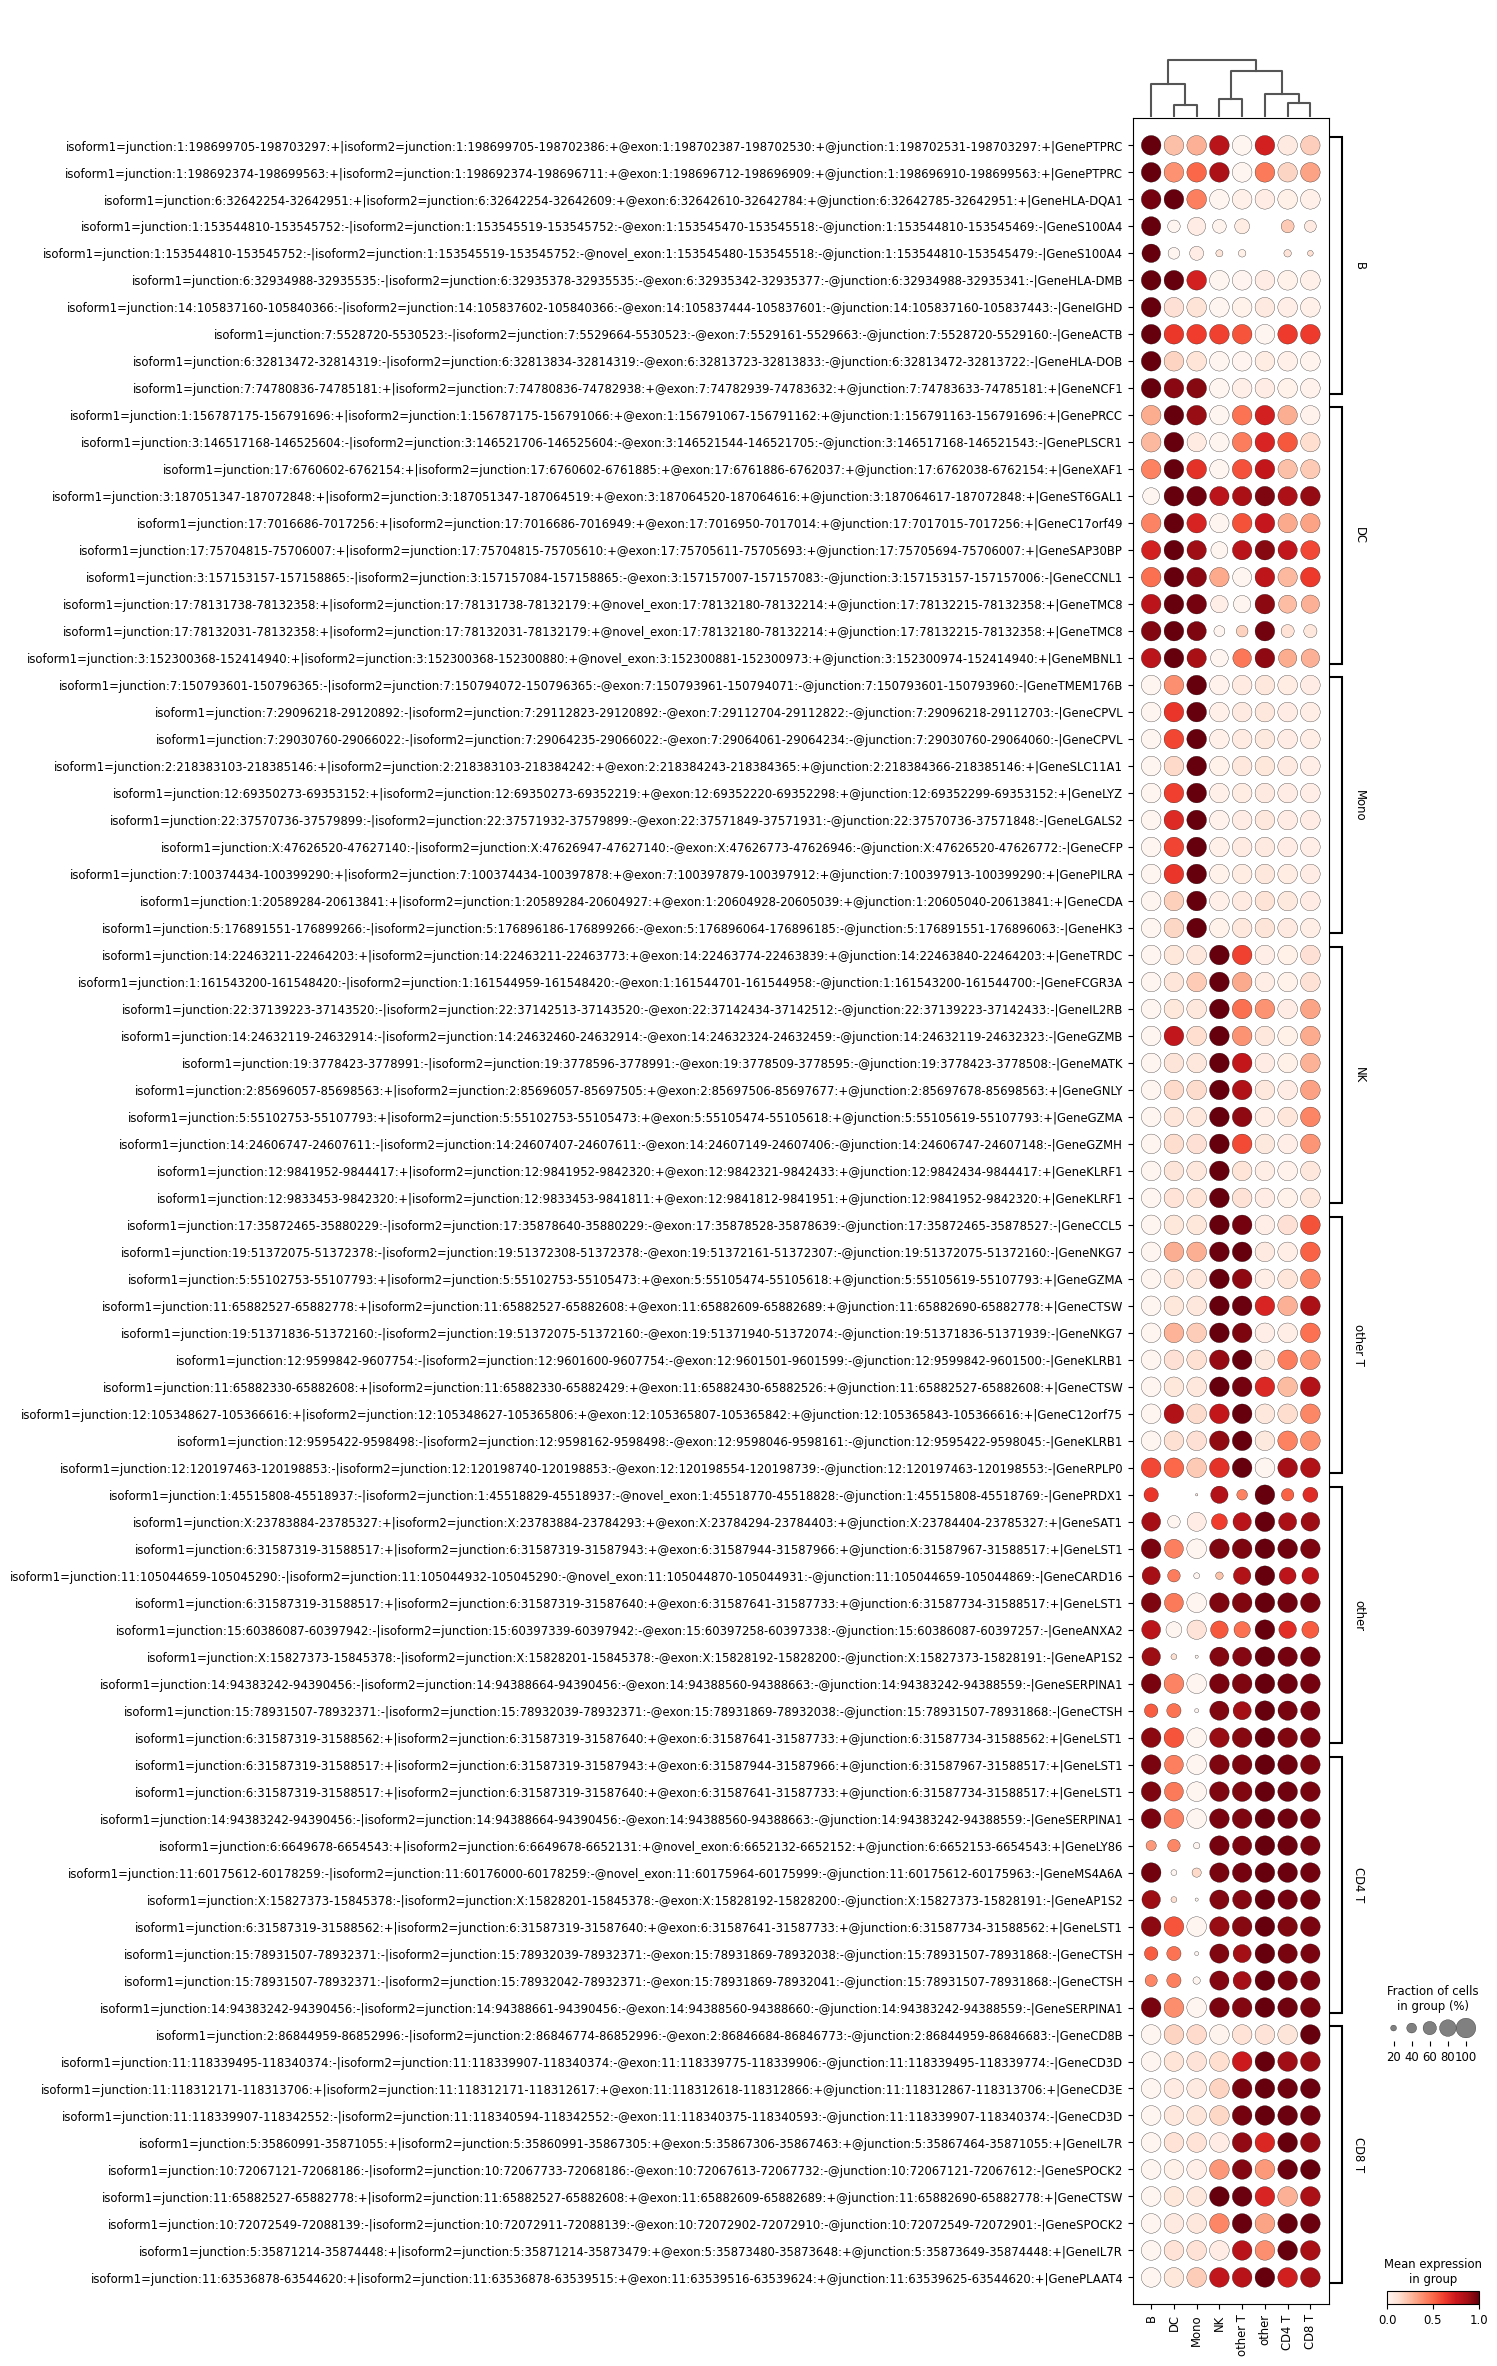

In [11]:
sc.pl.rank_genes_groups_dotplot(adata_knn, key="psi_DE_wilcoxon", n_genes=10, standard_scale='var', swap_axes=True, show=False)


In [12]:
#save the t-test results
result = adata_knn.uns['psi_DE_wilcoxon']
groups_id = result['names'].dtype.names
pd_wilcoxon = pd.DataFrame(
    {group.replace(" ", "") + '_' + key: result[key][group]
    for group in groups_id for key in ['names', 'pvals', 'pvals_adj', "logfoldchanges", "scores"]})

/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <AxesSubplot: >,
 'group_extra_ax': <AxesSubplot: >,
 'gene_group_ax': <AxesSubplot: >,
 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}

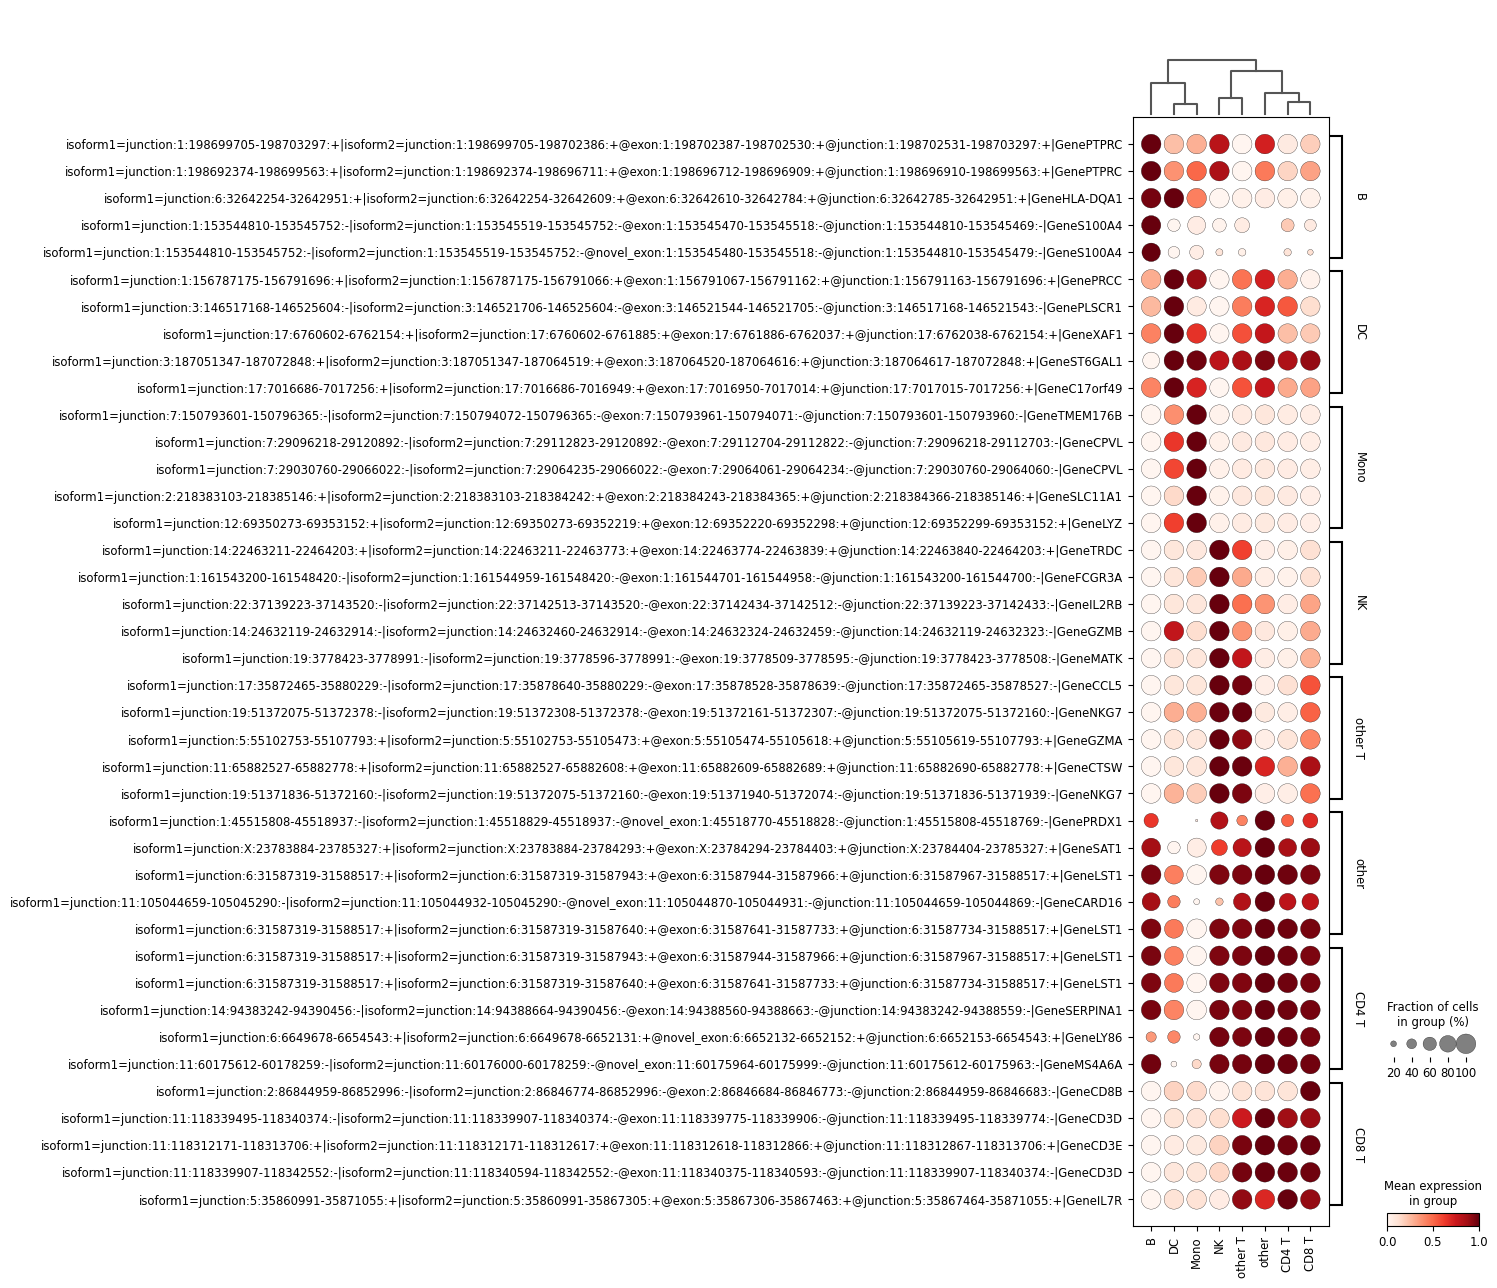

In [20]:
sc.pl.rank_genes_groups_dotplot(adata_knn, key="psi_DE_wilcoxon", n_genes=5, standard_scale='var', swap_axes=True, show=False)

/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <AxesSubplot: >,
 'group_extra_ax': <AxesSubplot: >,
 'gene_group_ax': <AxesSubplot: >,
 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}

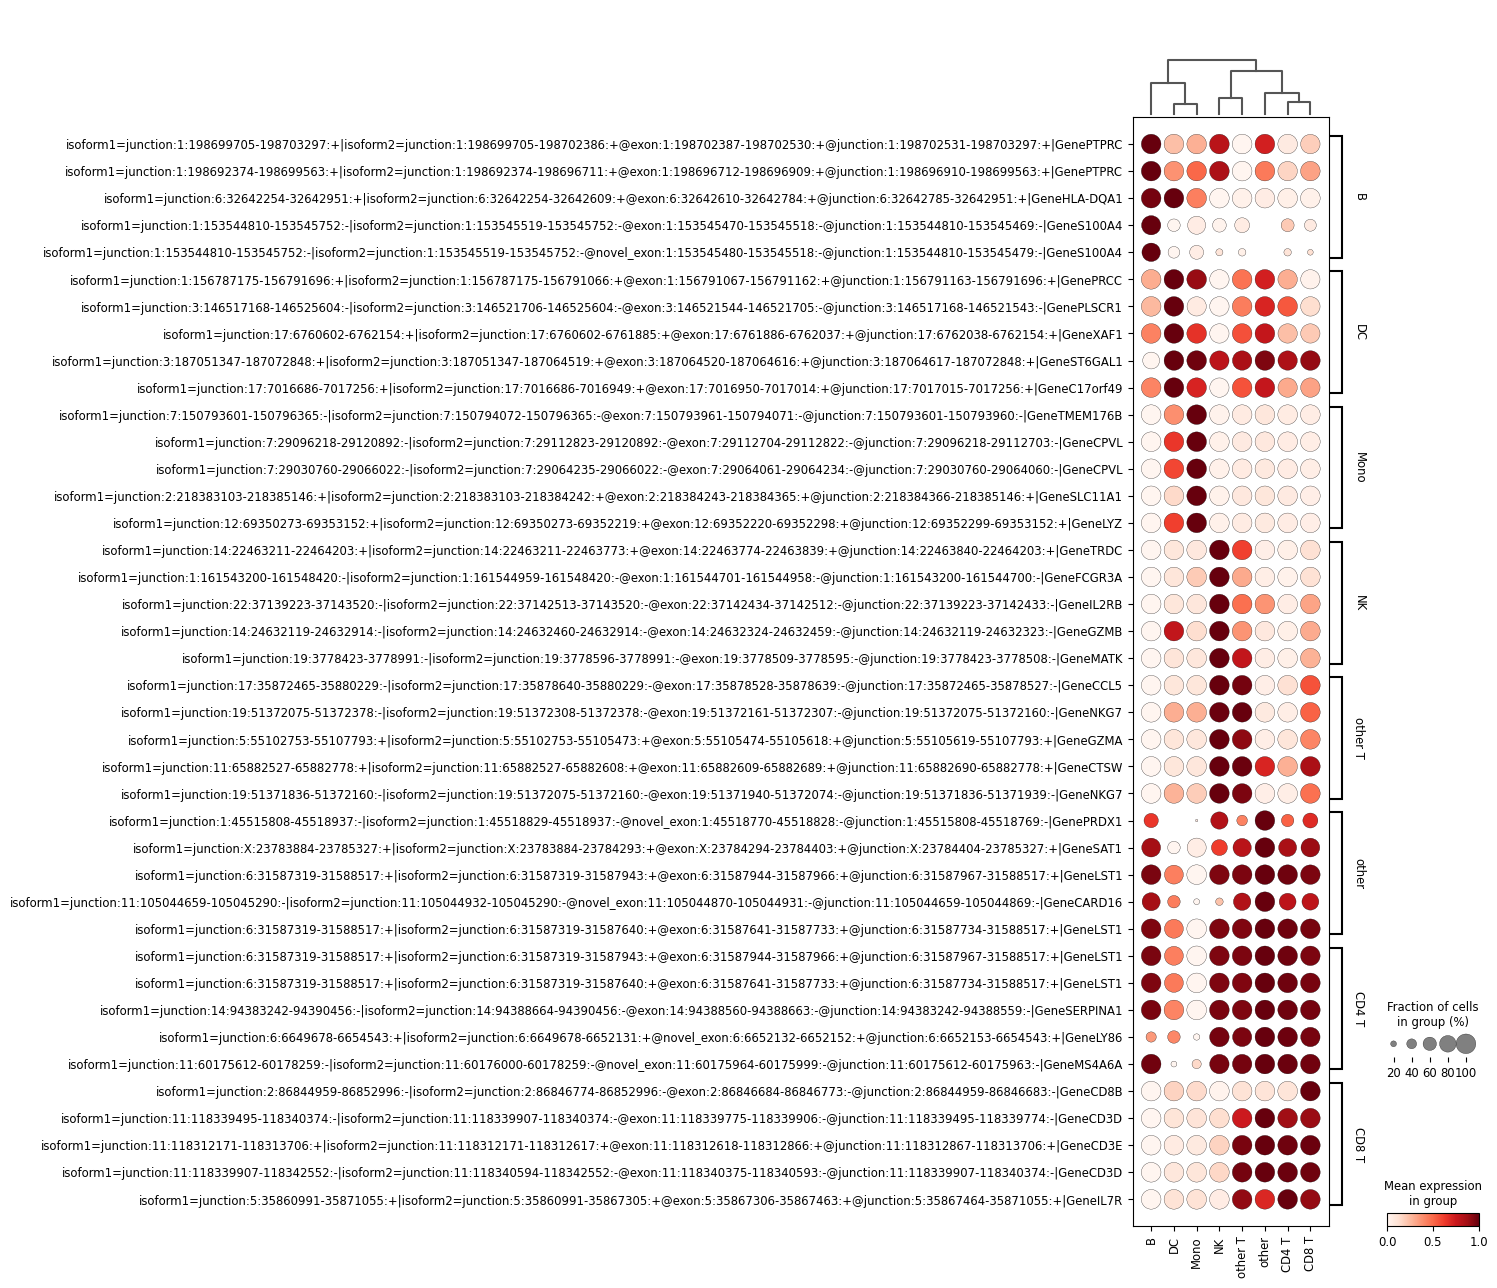

In [21]:
sc.pl.rank_genes_groups_dotplot(adata_knn, key="psi_DE_wilcoxon", n_genes=5, standard_scale='var', swap_axes=True, show=False)

/mnt/data/kailu/anaconda3/envs/dvaegpuEnv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


{'mainplot_ax': <AxesSubplot: >,
 'group_extra_ax': <AxesSubplot: >,
 'gene_group_ax': <AxesSubplot: >,
 'size_legend_ax': <AxesSubplot: title={'center': 'Fraction of cells\nin group (%)'}>,
 'color_legend_ax': <AxesSubplot: title={'center': 'Mean expression\nin group'}>}

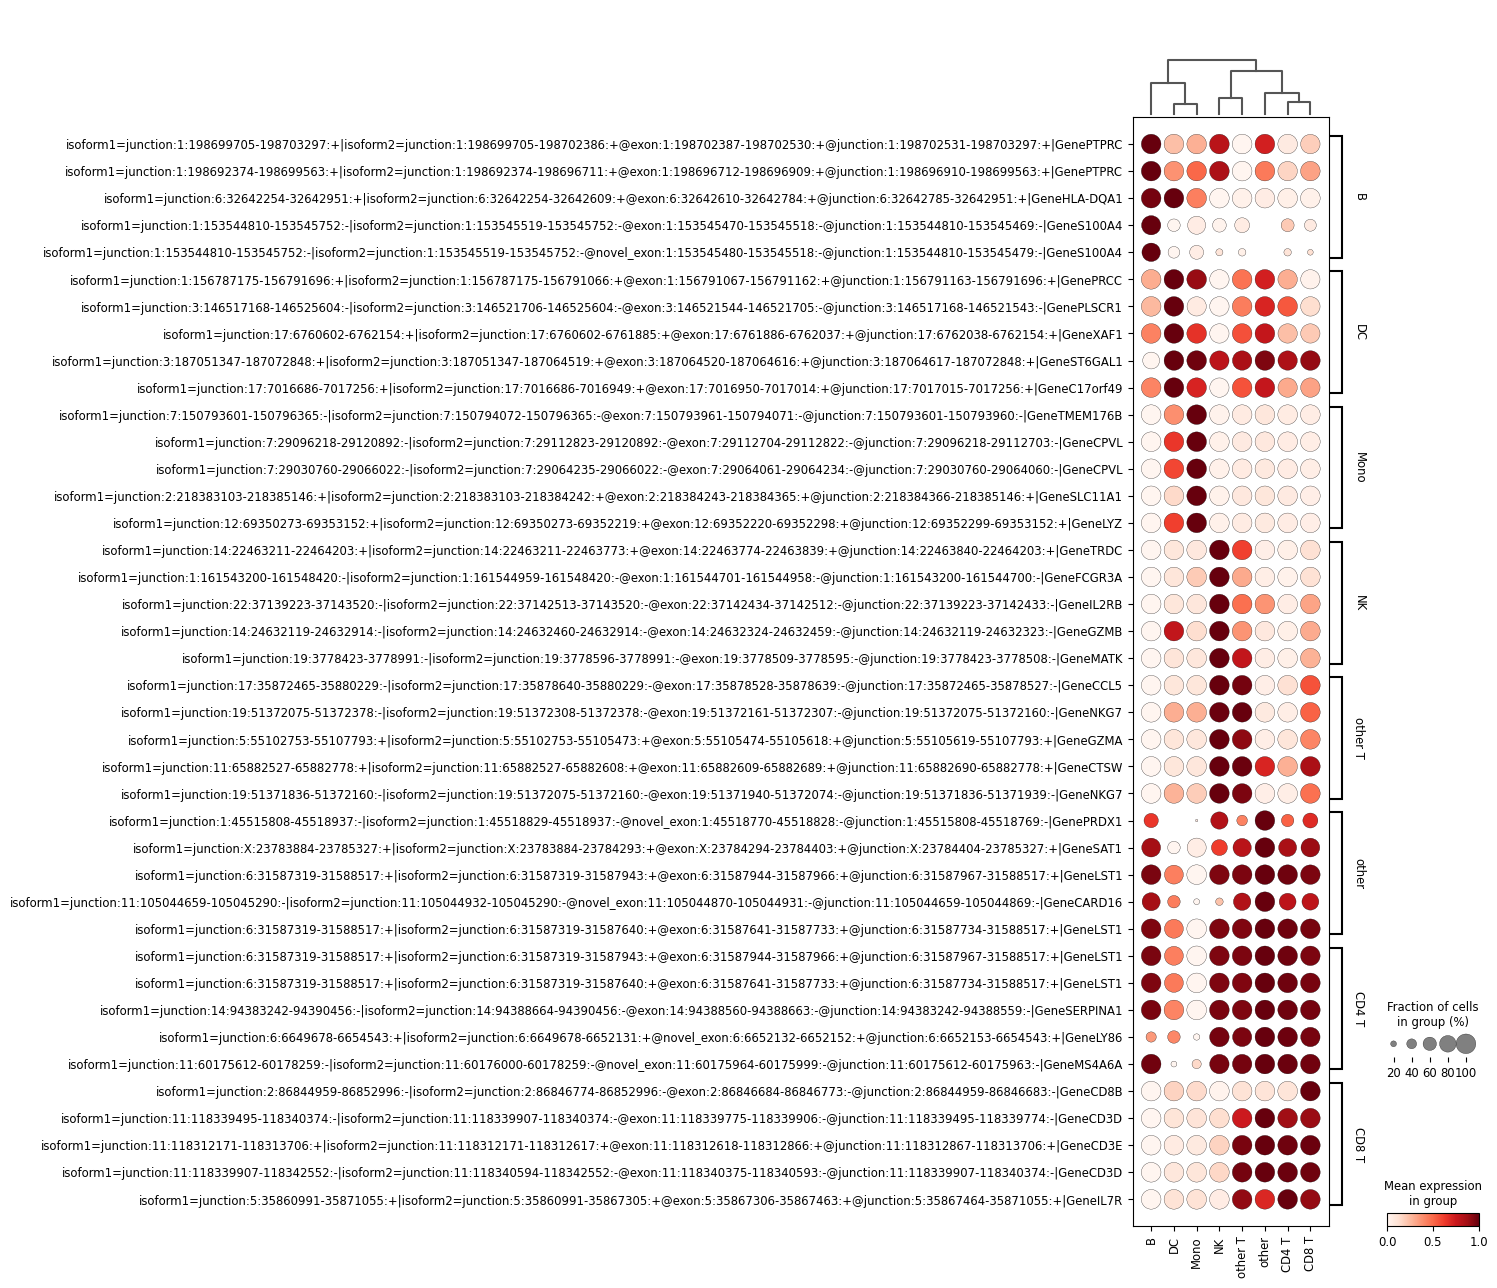

In [22]:
sc.pl.rank_genes_groups_dotplot(adata_knn, key="psi_DE_wilcoxon", n_genes=5, standard_scale='var', swap_axes=True, show=False)

## Go analysis

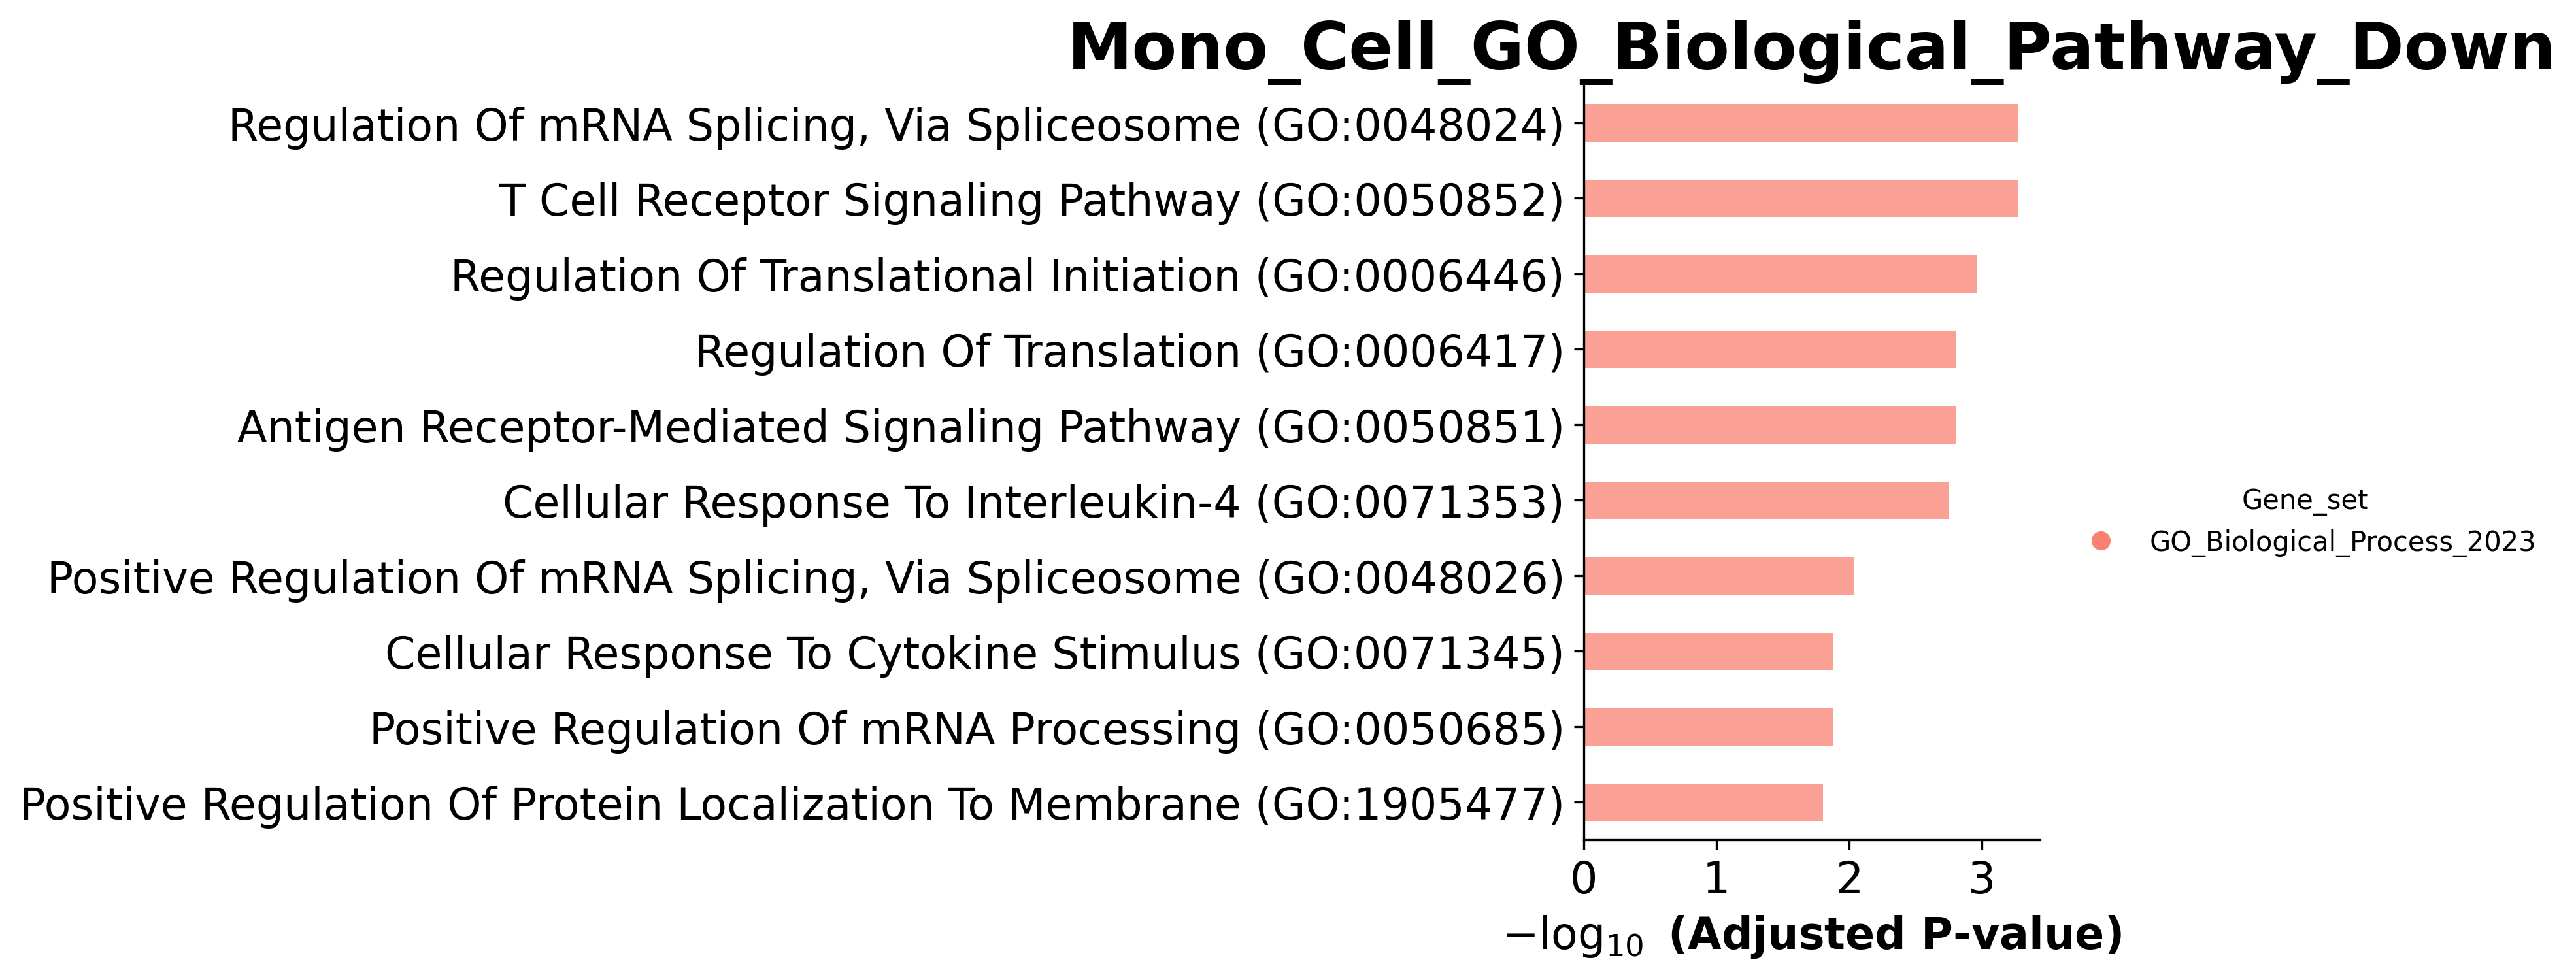

In [ ]:
## save final selected GO terms:
_current_cluster="Mono"
pd_t_test_temp =pd_t_test.loc[:, pd_t_test.columns.str.startswith(_current_cluster+'_')]
go_gene_list_down_temp = list(pd_t_test_temp[(pd_t_test_temp[_current_cluster+"_pvals_adj"] <= 0.05) & (pd_t_test_temp[_current_cluster+"_logfoldchanges"] >= 0.6)][_current_cluster+"_gene_names"])

#clean gene list to remove duplicate gene names
for x in go_gene_list_down_temp:
    if "," in x:
        go_gene_list_down_temp.remove(x)
        temp = x.split(",")
        go_gene_list_down_temp.extend(temp)
go_gene_list_down_temp = list(set(go_gene_list_down_temp))
go_enr_down = gp.enrichr(gene_list=go_gene_list_down_temp, # or "./tests/data/gene_list.txt",
            gene_sets=['GO_Biological_Process_2023'],
            organism='human'
)
# ax = dotplot(go_enr_down.res2d, title=_current_cluster+'_Cell_GO_Biological_Pathway_Down',cmap='viridis_r', size=10, figsize=(3,5))
with plt.rc_context({"figure.figsize":(5,4), "figure.dpi": (300)}):
    ax = barplot(go_enr_down.res2d,
                title=_current_cluster+'_Cell_GO_Biological_Pathway_Down',
                column="Adjusted P-value",
                group='Gene_set', # set group, so you could do a multi-sample/library comparsion
                size=10,
                top_term=10,
                figsize=(3,5)
                #color=['darkred', 'darkblue'] # set colors for group
                )    
